# Induction ThermographicClassification

Utilizing deep learning models like GoogleNet and ShuffleNet to classify thermographic images of induction motors, detecting levels of failures efficiently

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from urllib.request import urlretrieve
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as fn
import torchvision
from torchvision.transforms import Normalize
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import pandas as pd
import torch.nn.functional as F
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, f1_score
import csv

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
" https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/"

' https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/'

In [ ]:
from urllib.request import urlretrieve

url = "https://github.com/alecruces/Induction-Termographic-Classification/raw/main/IR-Motor-bmp.zip"
filename = "IR-Motor-bmp.zip"

# Download the file
urlretrieve(url, filename)

print("File downloaded successfully.")


File downloaded successfully.


In [ ]:
#!apt install unzip
!unzip /content/IR-Motor-bmp.zip

Archive:  /content/IR-Motor-bmp.zip
   creating: IR-Motor-bmp/
  inflating: __MACOSX/._IR-Motor-bmp  
   creating: IR-Motor-bmp/A&C30/
  inflating: __MACOSX/IR-Motor-bmp/._A&C30  
  inflating: IR-Motor-bmp/.DS_Store  
  inflating: __MACOSX/IR-Motor-bmp/._.DS_Store  
   creating: IR-Motor-bmp/A50/
  inflating: __MACOSX/IR-Motor-bmp/._A50  
   creating: IR-Motor-bmp/A&C&B30/
  inflating: __MACOSX/IR-Motor-bmp/._A&C&B30  
   creating: IR-Motor-bmp/A&B50/
  inflating: __MACOSX/IR-Motor-bmp/._A&B50  
   creating: IR-Motor-bmp/A10/
  inflating: __MACOSX/IR-Motor-bmp/._A10  
   creating: IR-Motor-bmp/Rotor-0/
  inflating: __MACOSX/IR-Motor-bmp/._Rotor-0  
   creating: IR-Motor-bmp/A30/
  inflating: __MACOSX/IR-Motor-bmp/._A30  
   creating: IR-Motor-bmp/Fan/
  inflating: __MACOSX/IR-Motor-bmp/._Fan  
   creating: IR-Motor-bmp/A&C&B10/
  inflating: __MACOSX/IR-Motor-bmp/._A&C&B10  
   creating: IR-Motor-bmp/Noload/
  inflating: __MACOSX/IR-Motor-bmp/._Noload  
   creating: IR-Motor-bmp/A&C10/


In [ ]:
imgs_path = "IR-Motor-bmp/"
file_list = glob.glob(imgs_path + "*")
print(file_list)
data = []
for class_path in file_list:
  class_name = class_path.split("/")[-1]
  for img_path in glob.glob(class_path + "/*.bmp"):
    data.append([img_path, class_name])

['IR-Motor-bmp/A&C&B30', 'IR-Motor-bmp/A&C30', 'IR-Motor-bmp/A30', 'IR-Motor-bmp/Noload', 'IR-Motor-bmp/A10', 'IR-Motor-bmp/A&C10', 'IR-Motor-bmp/A50', 'IR-Motor-bmp/Rotor-0', 'IR-Motor-bmp/A&C&B10', 'IR-Motor-bmp/Fan', 'IR-Motor-bmp/A&B50']


In [ ]:
def flip_and_save_image(image_path, flip_type):

    # Load the image
    image = cv2.imread(image_path)

    # Choose a flip randomly
    #flip_type = random.choice([-1, 0, 1])

    # Apply the chosen flip to the image
    flipped_image = cv2.flip(image, flip_type)

    # Get the image name and extension
    image_name = image_path.split('/')[-1]
    folder_path = image_path.rstrip(image_name)

    # Create new image path
    new_image_path = folder_path + 'flipped_' + image_name

    # Save the flipped image
    cv2.imwrite(new_image_path, flipped_image)

    return new_image_path

"""/
imgs_path = "IR-Motor-bmp/"
file_list = glob.glob(imgs_path + "*")
data =[]
for class_path in file_list:
  class_name = class_path.split("/")[-1]
  for img_path in glob.glob(class_path + "/*.bmp"):

    # Flip the image and get the new path
    flipped_img_path = flip_and_save_image(img_path)

    #if random.choice([True, False]):
    #  flipped_img_path = flip_and_save_image(img_path)

    #else:
    #  flipped_img_path = img_path

    data.append([img_path,class_name])

    data.append([flipped_img_path, class_name])

print(data)
/"""

'/\nimgs_path = "IR-Motor-bmp/"\nfile_list = glob.glob(imgs_path + "*")\ndata =[]\nfor class_path in file_list:\n  class_name = class_path.split("/")[-1]\n  for img_path in glob.glob(class_path + "/*.bmp"):\n\n    # Flip the image and get the new path\n    flipped_img_path = flip_and_save_image(img_path)\n\n    #if random.choice([True, False]):\n    #  flipped_img_path = flip_and_save_image(img_path)\n\n    #else:\n    #  flipped_img_path = img_path\n\n    data.append([img_path,class_name])\n\n    data.append([flipped_img_path, class_name])\n\nprint(data)\n/'

In [ ]:
#"""/
imgs_path = "IR-Motor-bmp/"
file_list = glob.glob(imgs_path + "*")
data =[]
for class_path in file_list:
  class_name = class_path.split("/")[-1]
  #print(class_path.split("/")[-1])
  for img_path in glob.glob(class_path + "/*.bmp"):
    data.append([img_path,class_name])

print(data)
#/"""

[['IR-Motor-bmp/A30/137.bmp', 'A30'], ['IR-Motor-bmp/A30/148.bmp', 'A30'], ['IR-Motor-bmp/A30/169.bmp', 'A30'], ['IR-Motor-bmp/A30/145.bmp', 'A30'], ['IR-Motor-bmp/A30/134.bmp', 'A30'], ['IR-Motor-bmp/A30/136.bmp', 'A30'], ['IR-Motor-bmp/A30/141.bmp', 'A30'], ['IR-Motor-bmp/A30/162.bmp', 'A30'], ['IR-Motor-bmp/A30/147.bmp', 'A30'], ['IR-Motor-bmp/A30/154.bmp', 'A30'], ['IR-Motor-bmp/A30/143.bmp', 'A30'], ['IR-Motor-bmp/A30/151.bmp', 'A30'], ['IR-Motor-bmp/A30/142.bmp', 'A30'], ['IR-Motor-bmp/A30/153.bmp', 'A30'], ['IR-Motor-bmp/A30/167.bmp', 'A30'], ['IR-Motor-bmp/A30/164.bmp', 'A30'], ['IR-Motor-bmp/A30/159.bmp', 'A30'], ['IR-Motor-bmp/A30/161.bmp', 'A30'], ['IR-Motor-bmp/A30/166.bmp', 'A30'], ['IR-Motor-bmp/A30/168.bmp', 'A30'], ['IR-Motor-bmp/A30/144.bmp', 'A30'], ['IR-Motor-bmp/A30/165.bmp', 'A30'], ['IR-Motor-bmp/A30/156.bmp', 'A30'], ['IR-Motor-bmp/A30/157.bmp', 'A30'], ['IR-Motor-bmp/A30/158.bmp', 'A30'], ['IR-Motor-bmp/A30/160.bmp', 'A30'], ['IR-Motor-bmp/A30/139.bmp', 'A30'], 

In [ ]:
print("Number of images: ", len(data))
print("Number of images per class: ", pd.DataFrame(data)[1].value_counts())

Number of images:  369
Number of images per class:  1
A&C&B30    42
A&C30      38
A&B50      38
A30        37
A50        35
A10        34
A&C10      31
A&C&B10    31
Rotor-0    30
Fan        28
Noload     25
Name: count, dtype: int64


In [ ]:
## Split in Test and Train

In [ ]:
# Splitting data into features (X) and labels (y)
X = [item[0] for item in data]
y = [item[1] for item in data]


#Splitting data into train and test sets with stratification
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

#Splitting data into train and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp,
                                                    test_size=0.2,
                                                    stratify=y_train_tmp,
                                                    random_state=42)

"""/
X_val = []
for img in X_val_:
  #fliptype = random.choice([-1, 0, 1])
  flip_type=1
  X_val.append(flip_and_save_image(img, flip_type))
/"""

# Merging X and y into data_train and data_test
data_train = [[X_train[i], y_train[i]] for i in range(len(X_train))]
data_val = [[X_val[i], y_val[i]] for i in range(len(X_val))]
data_test = [[X_test[i], y_test[i]] for i in range(len(X_test))]

In [ ]:
def count_label_proportions(dataset):
    total_items = len(dataset)
    label_proportions = defaultdict(float)
    for item in dataset:
        label_proportions[item[1]] += 1 / total_items
    return label_proportions

# Counting proportions for each label in data
label_proportions_data = count_label_proportions(data)

# Counting proportions for each label in data_train
label_proportions_train = count_label_proportions(data_train)

# Counting proportions for each label in data_test
label_proportions_test = count_label_proportions(data_test)


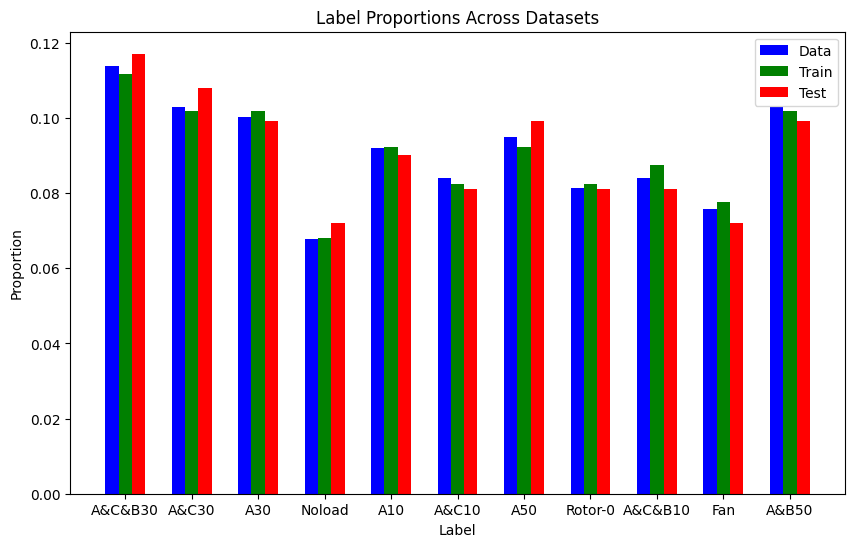

In [ ]:
def plot_label_proportions(label_proportions_data, label_proportions_train, label_proportions_test):
    labels = list(label_proportions_data.keys())
    data_proportions = [label_proportions_data[label] for label in labels]
    train_proportions = [label_proportions_train[label] for label in labels]
    test_proportions = [label_proportions_test[label] for label in labels]

    x = range(len(labels))

    plt.figure(figsize=(10, 6))
    plt.bar(x, data_proportions, width=0.2, color='b', align='center', label='Data')
    plt.bar([i + 0.2 for i in x], train_proportions, width=0.2, color='g', align='center', label='Train')
    plt.bar([i + 0.4 for i in x], test_proportions, width=0.2, color='r', align='center', label='Test')

    plt.xlabel('Label')
    plt.ylabel('Proportion')
    plt.title('Label Proportions Across Datasets')
    plt.xticks([i + 0.2 for i in x], labels)
    plt.legend()
    plt.show()

# Plotting label proportions
plot_label_proportions(label_proportions_data, label_proportions_train, label_proportions_test)


In [ ]:
#Calulate the mean and std of the Train data set
mean = 0
std = 0

for img_path, label in data_train:
  img = cv2.imread(img_path)
  mean += cv2.meanStdDev(img)[0]
  std += cv2.meanStdDev(img)[1]
train_mean = mean/len(data_train)
train_std = std/len(data_train)

#Mean and std for each channel
print(train_mean)
print(train_std )

[[99.71514456]
 [11.18873635]
 [43.27974559]]
[[25.38799053]
 [24.26099316]
 [52.49297173]]


In [ ]:
## Function to Preprocess image

In [ ]:
def preprocess_images(data, mean, std, image_size=(320, 240)):
    processed_images = []

    for img_path, label in data:
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)

        # Split channels
        b, g, r = cv2.split(img)

        # Normalize each channel
        b = b / 255
        g = g / 255
        r = r / 255

        # Standardize each channel
        b = (b - mean[0]) / std[0]
        g = (g - mean[1]) / std[1]
        r = (r - mean[2]) / std[2]

        # Merge channels
        processed_img = cv2.merge([r, g, b])
        processed_images.append([processed_img, label])

    return processed_images


In [ ]:
## Apply processed function to Data train and test

In [ ]:
#Mean and std recommended by Googlenet
googlenet_mean = [0.406, 0.456, 0.485]
googlenet_std = [0.225, 0.224, 0.229]

mean = googlenet_mean
std = googlenet_std

#mean = train_mean
#std = train_std

processed_train = preprocess_images(data_train, mean, std)
processed_val = preprocess_images(data_val, mean, std)
processed_test = preprocess_images(data_test, mean, std)

# Print the length of processed images
print("Number of processed images in the Train set:", len(processed_train))
print("Number of processed images in the Validation set:", len(processed_val))
print("Number of processed images in the Test set:", len(processed_test))

Number of processed images in the Train set: 206
Number of processed images in the Validation set: 52
Number of processed images in the Test set: 111


In [ ]:
## Create the Class of the Custom Dataset taking the image preprocessed

In [ ]:
class ProcessedImageTensor(Dataset):
    def __init__(self, processed_images):
        self.processed_images = processed_images
        self.class_map = {"A50" : 0, "A&C30" : 1, "Fan" : 2, "A30" : 3,
                          "Noload" : 4, "A&C&B10" : 5, "Rotor-0" : 6,
                          "A&B50" : 7, "A&C&B30" : 8, "A&C10" : 9, "A10" : 10}
    def __len__(self):
        return len(self.processed_images)

    def __getitem__(self, idx):
        img, label = self.processed_images[idx]
        class_id = self.class_map[label]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute((2,0,1))
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

# Assuming processed_images is a list of tuples (processed_img, label)
dataset_train = ProcessedImageTensor(processed_train)
dataset_val = ProcessedImageTensor(processed_val)
dataset_test = ProcessedImageTensor(processed_test)

# Access an example from the dataset
example_idx = 0
example_img, example_label = dataset_train[example_idx]

# Print the shape of the example image tensor
print(f"Example image shape: {example_img.shape}")
print(example_label)
print("Size of train: ", len(dataset_train))
print("Size of val: ", len(dataset_val))
print("Size of test: ", len(dataset_test))

Example image shape: torch.Size([3, 240, 320])
tensor([8])
Size of train:  206
Size of val:  52
Size of test:  111


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
## Specify class number
num_classes = len(set(y)) #11

In [ ]:
# Model
# Googlenet
#model = torchvision.models.googlenet(pretrained=False)

#shufflenet
model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=False)

#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
#0, 0.2, 0.3
drop_out_percentage = 0

# Replacing fully connected layer to match number of classes output
model.fc=nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=drop_out_percentage),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=drop_out_percentage),
    nn.Linear(in_features=128, out_features=32),
    nn.ReLU(),
    nn.Dropout(p=drop_out_percentage),
    nn.Linear(in_features=32, out_features=num_classes, bias=True)
)

# Freeze parameters of the rest of the network
for param in model.parameters():
    param.requires_grad = True

# Unfreeze parameters of the last layer for fine-tuning
for param in model.fc.parameters():
    param.requires_grad = True

model.double()
model.to(device);

model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  #iterator: dataloader
  #NOTA: revisar Batch
  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)

    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    # CrossEntpyLoss makes one hot encoding and uses softmax and Negative Log Likelihood
    loss = criterion(y_pred, y.squeeze())
    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  #return of the average loss and acc per epoch

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  #Logit to prob
  y_prob = F.softmax(y_pred, dim = -1)
  #Keep te idx of the higher prob = assign the most probable label
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  #See if the target is iqua to the predition (False, True) and then sum
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  #Calculate an average acuracy of the batch
  acc = correct.float()/y.shape[0]
  return acc

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for (x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y.squeeze())
      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)
      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  time_tracker = 0
  # Initialize validation loss
  best_valid_loss = float('inf')
  best_valid_f1 = 0
  epoch_best_model = 0

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []
  valid_f1 = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    labels, pred = predict(model, valid_iterator, device)
    metric_f1 = f1_score(labels, pred, average = "weighted")

    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
      epoch_best_model = epoch +1

    end_time = time.time()

    time_tracker += end_time-start_time

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%, F1: {metric_f1:.3f}")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_f1.append(metric_f1)

    #torch.save(model.state_dict(), model_save_path)

  mean_time = time_tracker /n_epochs

  print("\nEpoch:", epoch_best_model)
  print("\nMean Time:",  mean_time)

  return train_losses, train_accs, valid_losses, valid_accs, epoch_best_model, mean_time, valid_f1

In [ ]:
######## Training with Hyperparameter Tuning ##############

In [ ]:
## Hyperparameters:
# Hyperparameters
learning_rate = 1e-3
#8,16,32
batch_size = 32
num_epochs = 200
num_classes = len(set(y)) #11
optimizer_name = 'Adam'
momentum = 'NaN'
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.KLDivLoss(reduction="batchmean")

if optimizer_name == 'Adam':
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
else:
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


In [ ]:
#Apply DataLoader step
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
#Optimize my loss

In [ ]:
train_losses_googlenet, train_accs_googlenet, valid_losses_googlenet, valid_accs_googlenet, epoch_best_model, mean_time, valid_f1 = model_training(num_epochs,
                                                                                                            model,
                                                                                                            train_loader,
                                                                                                            val_loader,
                                                                                                            optimizer,
                                                                                                            criterion,
                                                                                                            device,
                                                                                                            'googlenet.pt')


Epoch: 1/200 -- Epoch Time: 6.34 s
---------------------------------
Train -- Loss: 2.249, Acc: 14.48%
Val -- Loss: 2.412, Acc: 4.69%, F1: 0.006

Epoch: 2/200 -- Epoch Time: 3.83 s
---------------------------------
Train -- Loss: 2.034, Acc: 18.81%
Val -- Loss: 2.481, Acc: 8.75%, F1: 0.017

Epoch: 3/200 -- Epoch Time: 3.15 s
---------------------------------
Train -- Loss: 1.841, Acc: 21.30%
Val -- Loss: 3.091, Acc: 8.75%, F1: 0.017

Epoch: 4/200 -- Epoch Time: 3.14 s
---------------------------------
Train -- Loss: 1.658, Acc: 24.17%
Val -- Loss: 4.201, Acc: 10.63%, F1: 0.017

Epoch: 5/200 -- Epoch Time: 3.28 s
---------------------------------
Train -- Loss: 1.467, Acc: 43.37%
Val -- Loss: 6.281, Acc: 10.63%, F1: 0.017

Epoch: 6/200 -- Epoch Time: 3.17 s
---------------------------------
Train -- Loss: 1.453, Acc: 33.04%
Val -- Loss: 4.877, Acc: 8.75%, F1: 0.026

Epoch: 7/200 -- Epoch Time: 3.21 s
---------------------------------
Train -- Loss: 1.268, Acc: 41.58%
Val -- Loss: 1.941

In [ ]:
results = {
    'Training accuracy': train_accs_googlenet,
    'Training loss': train_losses_googlenet,
    'Mean_training_time': mean_time,
    'Validation accuracy': valid_accs_googlenet,
    'Validation loss': valid_losses_googlenet,
    'Validation F1-score': valid_f1,
    'epoch_best_model': epoch_best_model
}

In [ ]:
# Create a new dictionary to store the best epoch values for each key
best_epoch_results = {}
best_epoch = results['epoch_best_model']

# Iterate over the keys in the results dictionary
for key, value in results.items():
  if key not in ['epoch_best_model', 'Mean_training_time']:
    # Store the best epoch value in the new dictionary
    best_epoch_results[key] = value[best_epoch-1]
  else:
    best_epoch_results[key] = value
# Print the new dictionary
print(best_epoch_results)

{'Training accuracy': 1.0, 'Training loss': 0.011288529755863528, 'Mean_training_time': 3.3107214379310608, 'Validation accuracy': 0.8875000178813934, 'Validation loss': 0.30714167403298565, 'Validation F1-score': 0.881547619047619, 'epoch_best_model': 88}


In [ ]:
from google.colab import files

# Create filename
filename = f"results_{batch_size}_{optimizer_name}_{drop_out_percentage}_{momentum}_{num_epochs}.csv"

# Save dictionary to CSV file with the filename
with open(filename, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=results.keys())
    writer.writeheader()
    writer.writerow(results)

files.download(filename)


# Create filename
filename_best = f"best_{batch_size}_{optimizer_name}_{drop_out_percentage}_{momentum}_{num_epochs}.csv"

# Save dictionary to CSV file with the filename
with open(filename_best, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=best_epoch_results.keys())
    writer.writeheader()
    writer.writerow(best_epoch_results)

files.download(filename_best)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for key, value in best_epoch_results.items():
    print(f"{key}: {value}")

Training accuracy: 1.0
Training loss: 0.011288529755863528
Mean_training_time: 3.3107214379310608
Validation accuracy: 0.8875000178813934
Validation loss: 0.30714167403298565
Validation F1-score: 0.881547619047619
epoch_best_model: 88


In [ ]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs, filename):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

  plt.savefig(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

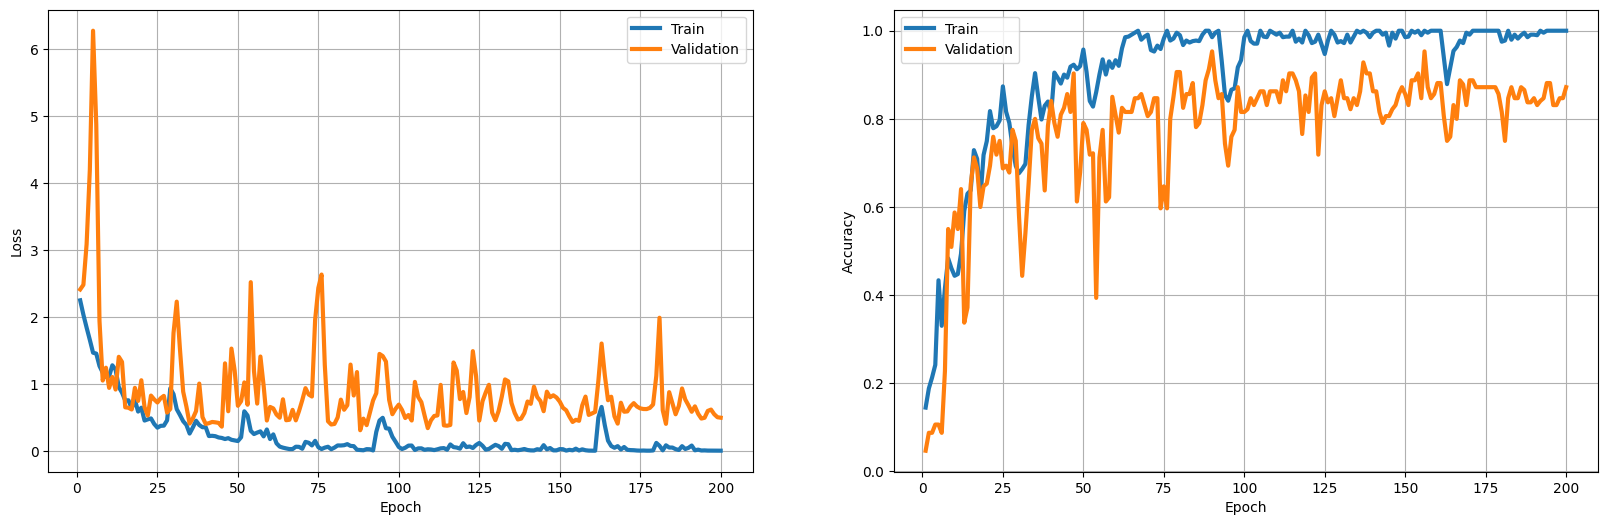

In [ ]:
filename_p1 = f"{batch_size}_{optimizer_name}_{drop_out_percentage}_{momentum}_{num_epochs}_1.png"
plot_results(num_epochs, train_losses_googlenet, train_accs_googlenet, valid_losses_googlenet, valid_accs_googlenet, filename_p1)

In [ ]:
def plot_results_f1(n_epochs, train_losses, train_accs, valid_losses, valid_accs, valid_f1, filename):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_f1, linewidth=3)
  _ = plt.legend(['Val Accuracy', 'Val F1 Score'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Proportion')

  plt.savefig(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

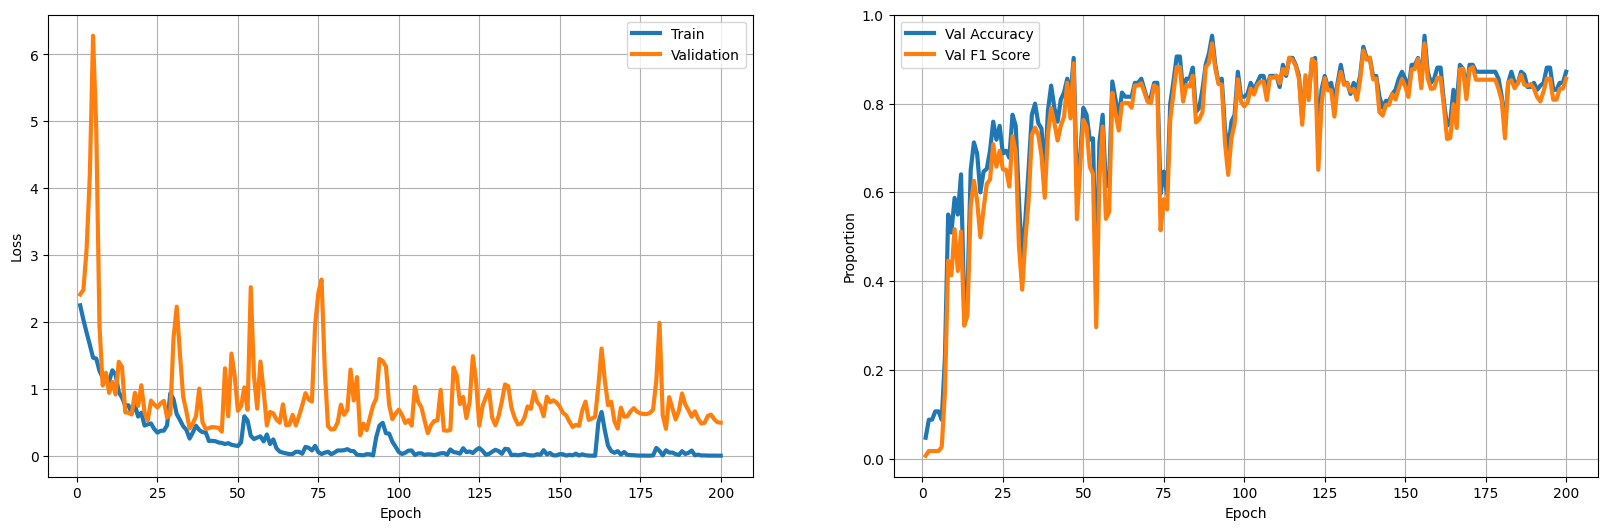

In [ ]:
filename_p2 = f"{batch_size}_{optimizer_name}_{drop_out_percentage}_{momentum}_{num_epochs}_2.png"
plot_results_f1(num_epochs, train_losses_googlenet, train_accs_googlenet, valid_losses_googlenet, valid_accs_googlenet,valid_f1, filename_p2)

In [ ]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  start_time = time.time()
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  end_time = time.time()
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %, Elapsed time: {end_time - start_time:.2f} seconds")


In [ ]:
model_testing(model, test_loader, criterion, device, 'googlenet.pt')

Test -- Loss: 0.511, Acc: 89.53 %, Elapsed time: 0.82 seconds


In [ ]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))
  print("\n")
  metrics = precision_recall_fscore_support(labels, pred, average='macro')
  print(metrics)

  f1_s =f1_score(labels, pred, average = "weighted")
  print(f1_s)

In [ ]:
print_report(model, test_loader, device)

[[ 9  0  0  0  0  0  0  0  2  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  2 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  5]
 [ 0  0  0  0  0  0  0  0  0  1  9]]


              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9
           7       0.85      1.00      0.92        11
           8       0.85      0.85      0.85        13
           9       0.80      0.44      0.57         9
      